# Introduction

Here, we will demonstrate the use of generalized additive models and trees. For this work, we will be reusing our Lab 2 dataset. I will reiterate that cross-validation must be done to have any confidence in your ML models. At the very least, a proper training/test split should be done.

As we move towards the end of this course, we are going to be working with much more sophisticated tools in the scikit-learn package. Specifically, one of the things we will use extensively is [sklearn.model_selection.GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV). This class allows us to scan a set of parameter values for a model and return the CV results.

In [7]:
import collections

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

from pymatgen import Composition

rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline
%config InlineBackend.figure_format ='retina'

from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold

In [2]:
# by default pandas will recognize NaN (sodium nitride) as nan (not a number)
# to turn off this behavior, we use na_filter=False
data = pd.read_csv("../../labs/lab2/data.csv", index_col=0, na_filter=False)

# Let's create a column of Composition objects using pymatgen.
data["composition"] = [Composition(f) for f in data["formula"]]

Here, we load the elemental data. Unlike lab2, we are simply going to disregard all elemental features that contain NaN. While imputing the mean value is a commonly used data science technique, it really does not work well for materials science problems. We will also use a smaller set of properties.

In [3]:
el_data = pd.read_csv("../../labs/lab2/element_properties.csv", index_col=0)
el_data = el_data[['AtomicRadius', 'AtomicWeight', 'Column', 'Electronegativity', 'Row']]

As before, we will compute the mean, min, and max for every elemental feature. For mean, we are weighting it by composition. As before, we drop all data points that contain NaN.

In [4]:
props = collections.defaultdict(list)

for comp in data["composition"]:
    for c in el_data.columns:
        vals = [el_data[c][el.symbol] * amt for el, amt in comp.items()]
        props["%sMean" % c].append(sum(vals)/ comp.num_atoms)
        props["%sMin" % c].append(min(vals))
        props["%sMax" % c].append(max(vals))
data = data.assign(**props)
data = data.dropna()
print(data.shape)

(124342, 21)


We are left with around 106k data points, Still more than enough for our purposes. Let's create our features and targets.

In [5]:
features = [c for c in data.columns if c.endswith("Mean") or c.endswith("Min") or c.endswith("Max")]
x = data[features]
y_class = [0 if bg < 1e-4 else 1 for bg in data["band_gap"]]
y_reg = data["band_gap"]

Before we proceed further, let us write up some reusable methods to standardize the analysis of different ML models. Copy and pasting code is fine for earlier demos to reiterate the API of scikit-learn, but it is very bad programming practice. By this stage of the course, we want to do things better.

In [15]:
def plot_grid_search_results(gs, ylim=None):
    """
    Plots the results of GridSearchCV.
    """
    results = pd.DataFrame(gs.cv_results_)
    for c in results.columns:
        # Note that here we are working with just variations in one parameter.
        # So we can automatically find the name of that parameter.
        if c.startswith("param_"):
            x = c
            break
    fig, ax = plt.subplots(figsize=(16, 8))    
    #ax = sns.barplot(x=x, y="mean_train_score", data=results)
    ax = sns.barplot(x=x, y="mean_test_score", data=results)
    plt.xlabel(x)
    if ylim:
        plt.ylim(ylim)
    #ax.legend(["Train", "Test"], loc=2);
    
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Neural Networks

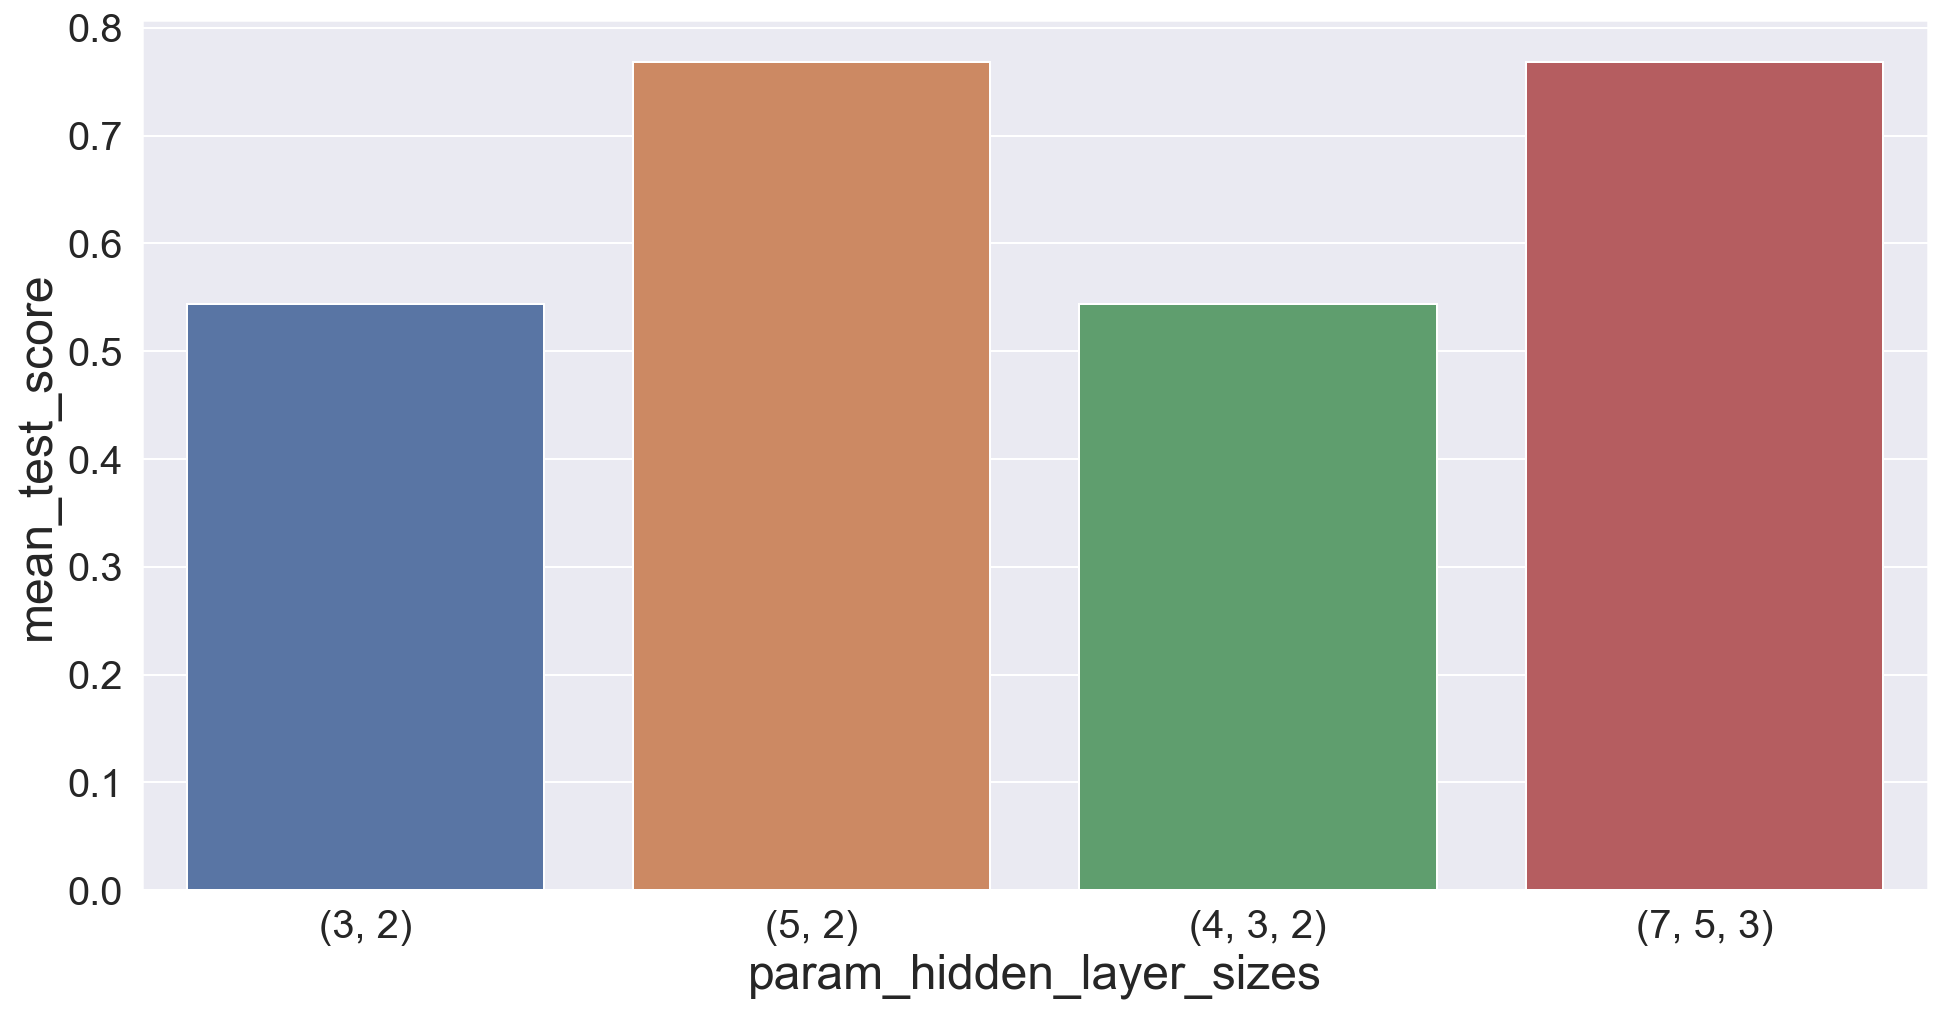

In [17]:
nn = MLPClassifier(alpha=1e-4, random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"hidden_layer_sizes": [(3, 2), (5, 2), (4, 3, 2), (7, 5, 3)]},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)

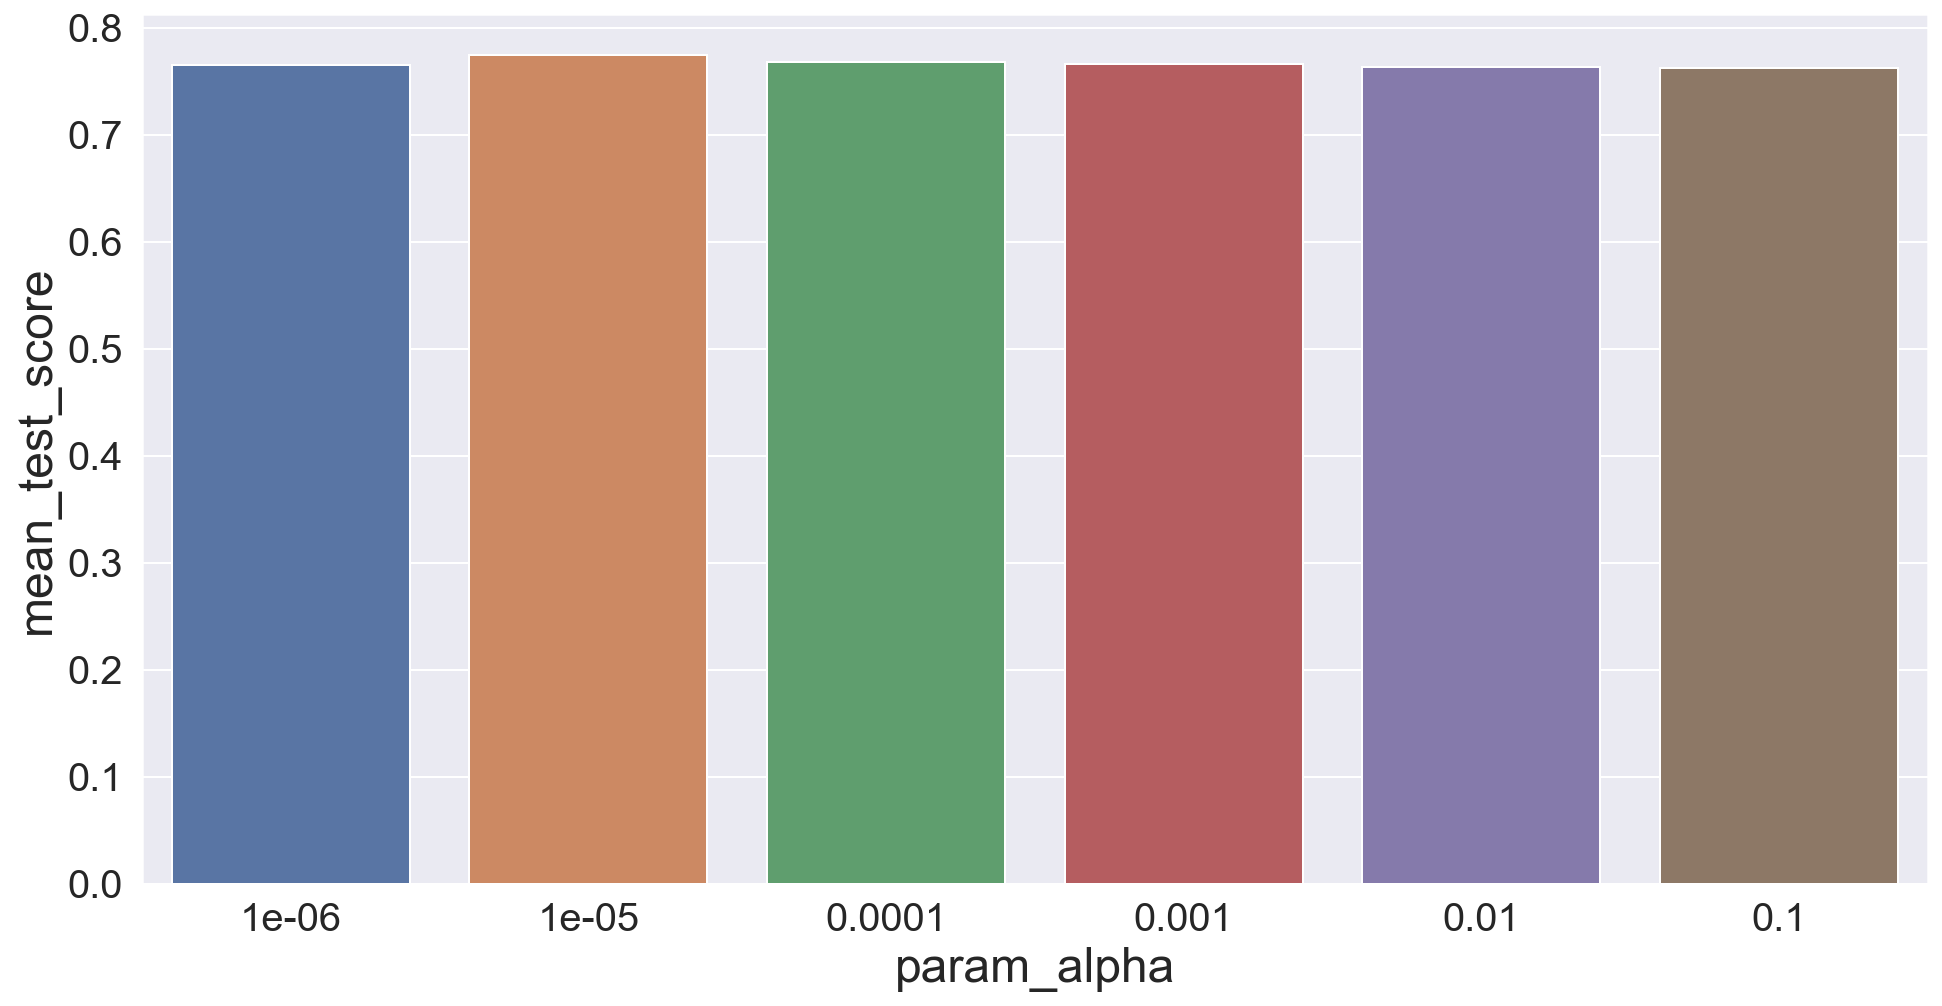

In [20]:
nn = MLPClassifier(hidden_layer_sizes=(7, 5, 3), random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"alpha": np.logspace(-6, -1, 6)},
    return_train_score=True,
    scoring="accuracy",
    cv=kfold
)
gs.fit(x, y_class)
plot_grid_search_results(gs)

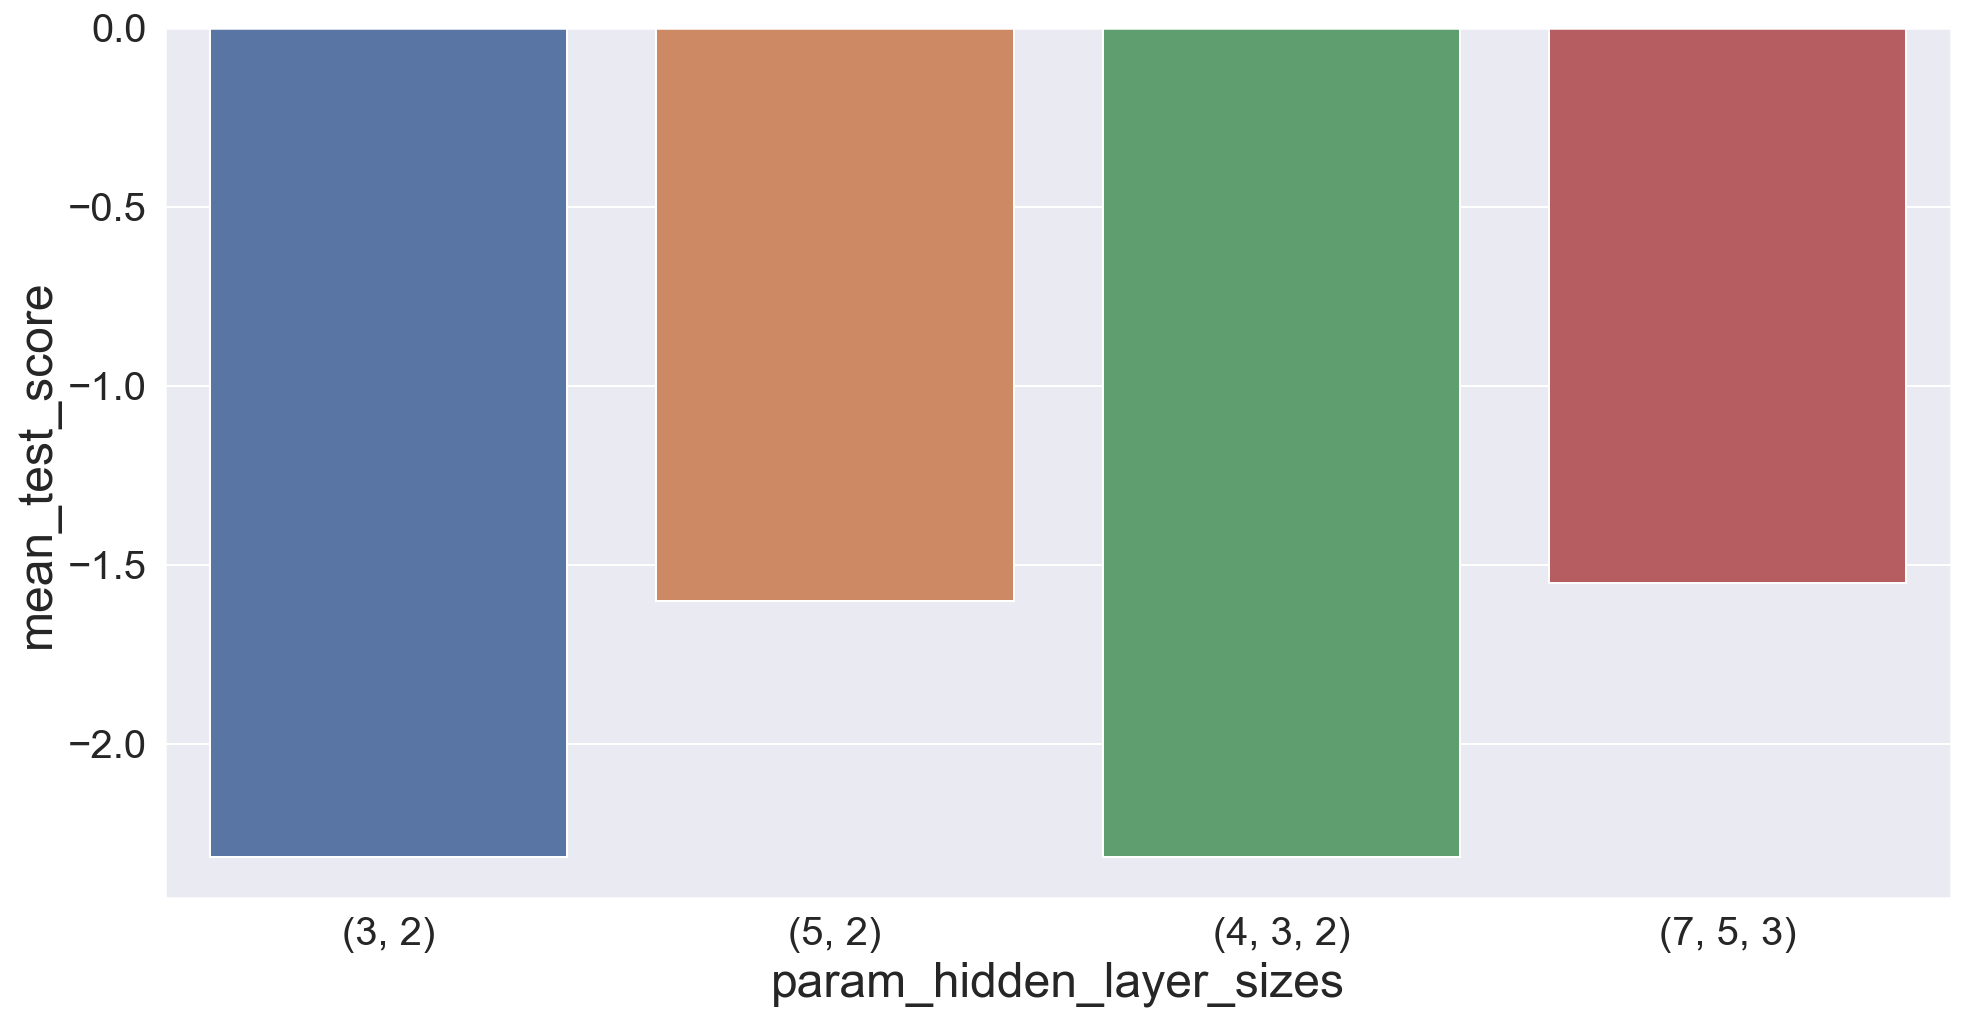

In [21]:
nn = MLPRegressor(alpha=1e-4, random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"hidden_layer_sizes": [(3, 2), (5, 2), (4, 3, 2), (7, 5, 3)]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)

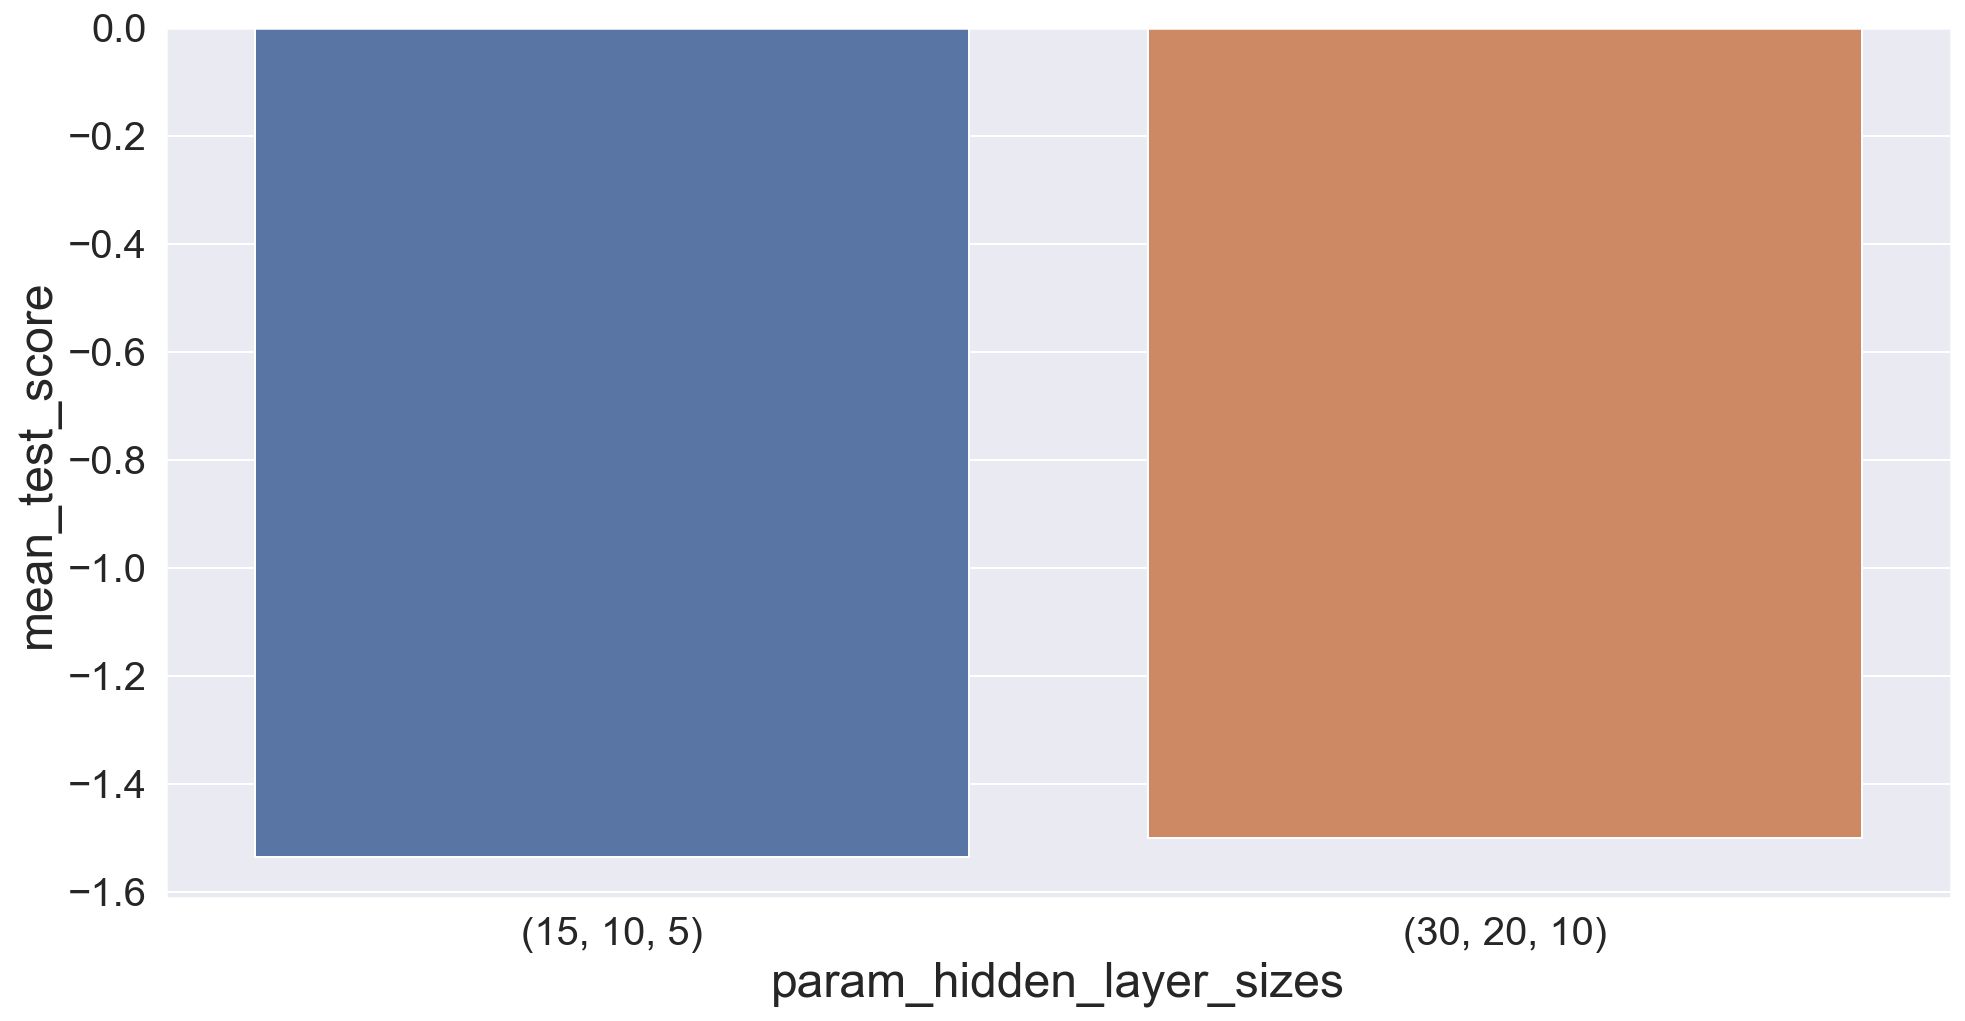

In [22]:
nn = MLPRegressor(alpha=1e-4, random_state=1, learning_rate_init=0.01)
gs = GridSearchCV(
    nn,
    param_grid={"hidden_layer_sizes": [(15, 10, 5), (30, 20, 10)]},
    return_train_score=True,
    scoring="neg_mean_squared_error",
    cv=kfold
)
gs.fit(x, y_reg)
plot_grid_search_results(gs)